In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only one function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](http://matthewrocklin.com/blog/work/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Users of Colab** (and other users) can download the supporting files for this lesson is they don't have them already:

In [1]:
# Download data and solutions

import urllib.request
import os

def download_data(path):
    if os.path.exists(path):
        return
    if not os.path.exists('data'):
        os.mkdir('data')
    if not os.path.exists('solutions'):
        os.mkdir('solutions')
    url = 'https://raw.githubusercontent.com/ualberta-rcg/python-dask/master/notebooks/' + path
    output_file = path
    urllib.request.urlretrieve(url, output_file)
    print("Downloaded " + path)

def show_solution(file):
    fp = open('solutions/{}'.format(file), 'r')
    print(fp.read())

download_data('solutions/delayed-loop.py')
download_data('solutions/delayed-control-flow.py')


Downloaded solutions/delayed-loop.py
Downloaded solutions/delayed-control-flow.py


## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [4]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

print("z is", z)

z is 5
CPU times: user 17.8 ms, sys: 1.89 ms, total: 19.7 ms
Wall time: 3 s


### Parallelize with `dask.delayed`

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We can call dask.delayed on our funtions to make them lazy. Rather than compute their results immediately, they record what we want to compute as a task into a graph that we’ll run later on parallel hardware.

In [5]:
# Install prerequisites, if needed ...
# !pip install pandas numpy dask distributed graphviz bokeh dask_jobqueue mimesis requests matplotlib

In [8]:
from dask import delayed

In [15]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z: int = delayed(add)(x, y)

CPU times: user 610 µs, sys: 0 ns, total: 610 µs
Wall time: 547 µs


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [17]:
%%time
# This actually runs our computation using a local thread pool

z.compute()
print(type(z))

<class 'dask.delayed.Delayed'>
CPU times: user 13.2 ms, sys: 3.47 ms, total: 16.7 ms
Wall time: 2 s


## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

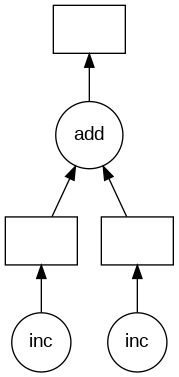

In [18]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [20]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [25]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
print("total is", total)

total is 44
CPU times: user 44.4 ms, sys: 3.86 ms, total: 48.2 ms
Wall time: 8 s


The code above is copied below.
Try to parallelize it using `dask.delayed`.

In [26]:
%%time
# Your parallel code here...

results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
result = total.compute()
print("total is", total)

total is Delayed('sum-f093f025-f59a-4d6d-ba0a-80c7b20e6b10')
CPU times: user 24.4 ms, sys: 6.27 ms, total: 30.7 ms
Wall time: 4.01 s


In [27]:
# PRINT SOLUTION (copy/paste output into a cell to run)
show_solution('delayed-loop.py')

results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

# Let's see what type of thing total is
print("Printing total: ", total)

# Compuing ...
result = total.compute()
print("Printing result from computing total:", result)



How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delay`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```

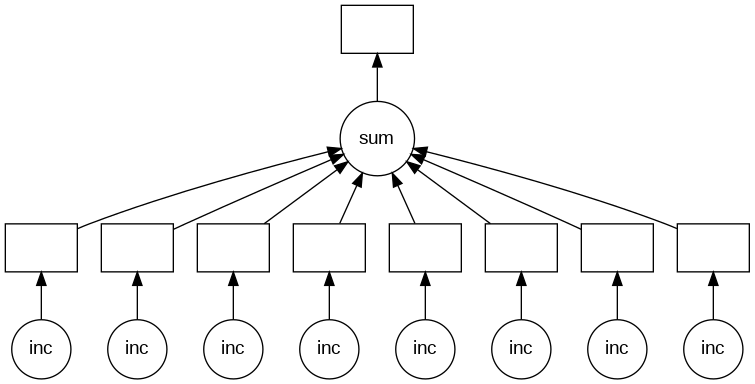

In [28]:
total.visualize()

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [29]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [32]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)

total = sum(results)
print(total)

90
CPU times: user 50.9 ms, sys: 5.36 ms, total: 56.2 ms
Wall time: 10 s


The code above is copied in the next cell. Parallelize it to run more efficiently.

Delayed('sum-6223b4e3-0bf1-4d65-ace8-e727cbe12fec')
CPU times: user 35.4 ms, sys: 5.14 ms, total: 40.5 ms
Wall time: 5.05 s


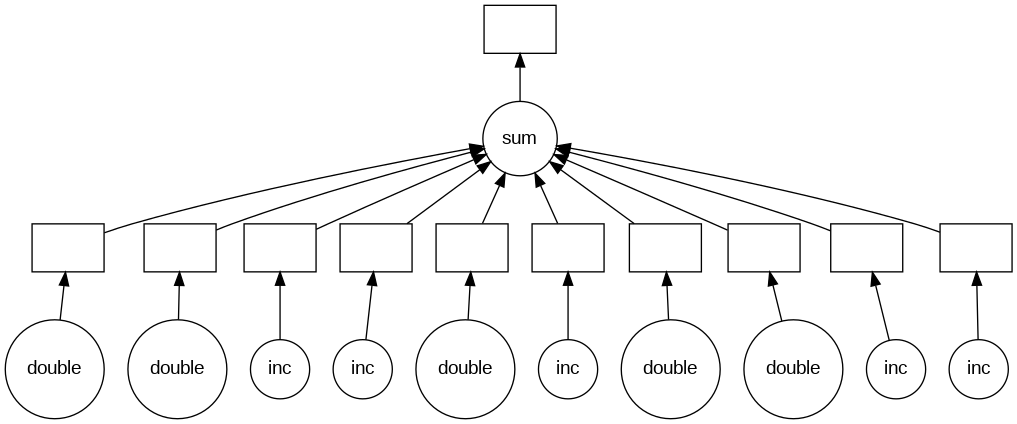

In [34]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
result = total.compute()
print(total)
total.visualize()

In [35]:
# PRINT SOLUTION (copy/paste output into a cell to run)
show_solution('delayed-control-flow.py')

results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
result = total.compute()
print(result)



### Some things to try:

* Print out the execution graph of the computation above;
* Try delaying `is_even(x)` in the example.


[On to the next notebook (`Dask Schedulers`)](03-schedulers.ipynb) ...